In [17]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [11]:
train_dir = "/kaggle/input/oral-disease-dataset/TRAIN"
test_dir = "/kaggle/input/oral-disease-dataset/TEST"

Setting Image Dimensions

In [12]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

Data Generators with Augmentation for Training Data

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,         # Rotating images up to 20 degrees
    width_shift_range=0.2,     # Shifting images horizontally up to 20%
    height_shift_range=0.2,    # Shifting images vertically up to 20%
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True       # Random horizontal flip
)

Normalizing Test Images

In [14]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

Preparing Data Loaders

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1486 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


Building the Model

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 Regularization
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification: 1 output neuron
])

Compiling the Model

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

Defining Callbacks

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

Training the Model

In [21]:
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.6258 - loss: 1.8458 - val_accuracy: 0.8235 - val_loss: 0.7020 - learning_rate: 0.0010
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 501ms/step - accuracy: 0.7520 - loss: 0.6540 - val_accuracy: 0.7377 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - accuracy: 0.7609 - loss: 0.5743 - val_accuracy: 0.7549 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - accuracy: 0.7799 - loss: 0.5575 - val_accuracy: 0.8897 - val_loss: 0.4012 - learning_rate: 0.0010
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 491ms/step - accuracy: 0.8184 - loss: 0.4690 - val_accuracy: 0.8971 - val_loss: 0.3739 - learning_rate: 0.0010
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.8327 - loss: 0.4616 - val_accuracy: 0.8971 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 497ms/step - accuracy: 0.8500 - loss: 0.4025 - val_

Evaluating the Model

In [22]:
print("\nEvaluating the Model:")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating the Model:
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8869 - loss: 0.3278
Test Loss: 0.2724
Test Accuracy: 0.9142


Confusion Matrix and Classification Report

In [23]:
print("\nGenerating Confusion Matrix and Classification Report:")
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()
true_classes = test_generator.classes

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Generating Confusion Matrix and Classification Report:
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
Confusion Matrix:
[[184  20]
 [ 15 189]]

Classification Report:
              precision    recall  f1-score   support

      Caries       0.92      0.90      0.91       204
  Gingivitis       0.90      0.93      0.92       204

    accuracy                           0.91       408
   macro avg       0.91      0.91      0.91       408
weighted avg       0.91      0.91      0.91       408



Saving the Model

In [24]:
model.save("oral_disease_classification_model_updated.h5")
print("\nModel saved as 'oral_disease_classification_model_updated.h5'")


Model saved as 'oral_disease_classification_model_updated.h5'


Plotting Training and Validation Metrics

In [25]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

1. Plotting Accuracy

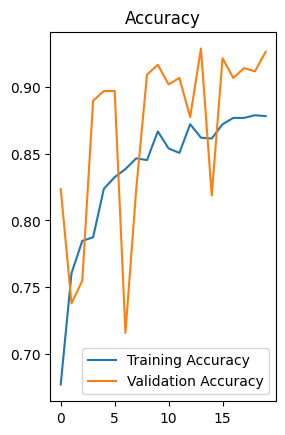

In [26]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

2. Plotting loss

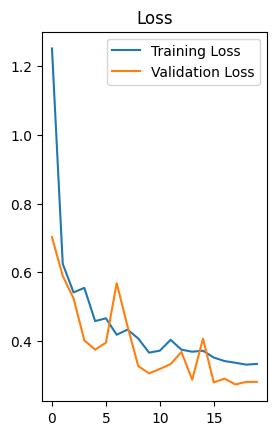

In [27]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()